Now these are the steps that were used in this classification algorithm

1. we imported all the dependencies
2. load MNIST dataset as one hot vector
3. convert one hot vector into classes as single member
4. now create data dimensions
5. create helper function for plotting images
6. Now define placeholder variables for tensorflow
7. define wights and biases
8. create a model - here we used a simple model multiplying input with weights and adding biases
9. then create a cost variable using cross_entropy to know how well model predicts value
10. Then use the cost variable to create an optimiser - we used gradient descent
11. define Performance Measures for better readability
12. create tensorflow session
13. define a helper optimisation function to sort through the input in batches instead of bulk input
14. optional steps - create helper function for showing performance, showing model weights , showing errors
15. test accuracy at different thresholds

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [12]:
# We know thatMNISt images are 28 pixels in each dimension
img_size = 28

# Images are stored in a one-dimensional array of this length
img_size_flat = img_size * img_size

# Tuple with height and width of images used ot reshape arrays.
img_shape = (img_size, img_size)

#Number of classes, one class for each of 10 digits.
num_classes = 10

In [13]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #Create figure with 3x3 subplots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #Plot image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        #Show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        #Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell
    plt.show()

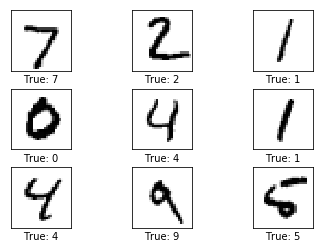

In [14]:
#test few images
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images, cls_true=cls_true)


In [15]:
# now we initialise place holder values for input
x = tf.placeholder(tf.float32, [None, img_size_flat])
# placeholder(datatype, [None means any no. of array, each of size img_size_flat])

In [16]:
# now we put placeholder value for true labels 
y_true = tf.placeholder(tf.float32, [None, num_classes])

# placeholder foreach class
y_true_cls = tf.placeholder(tf.int64, [None])

In [17]:
# apart from the placeholder variables that were defined above we also 
# have to initialise certain parameters in tensorflow in order to get 
# optimum performance

#first we define a tf variable initialised with zeros and whose shape 
#is [image_size_flat,num_classes] so basically a matrix or a tensor

weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))

In [18]:
#second variable for optimising is biases
biases = tf.Variable(tf.zeros([num_classes]))

In [19]:
#now we create a simple Model that multiplies the placeholder value x 
#with weights and adds the biases

logits = tf.matmul(x,weights) + biases

#logits is now a matrix that tells us how likely it is for an ith image to belong to jth class

In [20]:
# as the no. in logits can be a very large number we need to normalise the dat
# so that we get a value between zero and one
# so we use softmax algorithm

y_pred = tf.nn.softmax(logits)

In [21]:
# predicted class can be calculated from y_pred matrix by taking index of
# maximum in each row
y_pred_cls = tf.argmax(y_pred, axis=1)

In [22]:
# we need to ensure that we can change weights and biases of the model
# by comparing the y_pred value to the y_true value

#so we use cross-entropy a performance measure a function in tensorflow
#if cross entrpy is zero it means y_pred matches with y_true
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

# we need a single scalar value so we average all cross_entropy value 
cost = tf.reduce_mean(cross_entropy)

In [23]:
#now we ned to create an optimisation method - Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)


In [25]:
#now inititalise some variables that tell uaer if prediction is true or not
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

#we can calculate the average of this number
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [26]:
# creating TensorFlow session
session = tf.Session()

In [27]:
#initialize tf.Variables by tf function
session.run(tf.global_variables_initializer())

In [37]:
# Since it takes a long time to apply gradient descent to 55000 test 
# datasets, we will instead develop a helper funciton that will help
# optimise first using Stochastic Gradient Descent
# this is done by iterating over a small batch size every turn

batch_size = 100

# the optimize function
def optimize(num_iterations):
    for i in range(num_iterations):
        # each x_batch hold the sample batch data while y_true_batch holds true label for the batch
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with proper names
        # for placeholder variables in the TensorFlow groph.
        feed_dict_train = {x: x_batch,
                          y_true: y_true_batch}
        
        #Now we can run optimiser using this batch and feed_dict_train dictionary
        session.run(optimizer, feed_dict=feed_dict_train)
        

In [38]:
#Now we need to create a Helper function to show performance

feed_dict_test = {x:data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}
# funciton to print accuracy
def print_accuracy():
    #Use TensorFlow to compute teh accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    #print the accuracy
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [50]:
#now lets try and print the confusion matrix

def print_confusion_matrix():
    #Get the true classifiaction for the test-set
    cls_true = data.test.cls
    
    #Get the predicted classification for the test-set
    cls_pred = session.run(y_pred_cls , feed_dict = feed_dict_test)
    
    #get confusion matrix using scikit learn
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    
    #Print teh confusion matrix as text
    print(cm)
    
    #plot the confusion matrix as an image 
    plt.imshow(cm, interpolation='nearest' , cmap=plt.cm.Blues)
    
    #make minor adjustments to plot
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    #and finally
    plt.show()


In [51]:
#to plot the example errors

def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    #Negate the boolean array
    incorrect = (correct == False)
    
    #get the images that are wrongly classified
    images = data.test.images[incorrect]
    
    #get the predicted classes for those images
    cls_pred = cls_pred[incorrect]
    
    #get the true classes for those images
    cls_true = data.test.cls[incorrect]
    
    #plot the images
    plot_images(images= images[0:9],
               cls_true = cls_true[0:9],
               cls_pred=cls_pred[0:9])

In [52]:
def plot_weights():
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()    
    

In [53]:
print_accuracy()

Accuracy on test-set: 92.0%


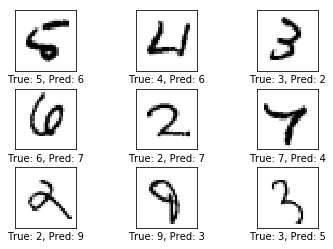

In [54]:
plot_example_errors()

In [55]:
#after optimisation

optimize(num_iterations=1)

In [56]:
print_accuracy()

Accuracy on test-set: 90.9%


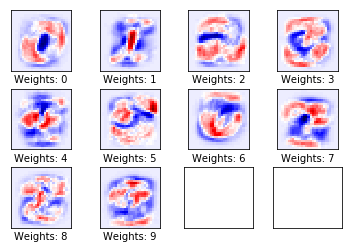

In [57]:
plot_weights()

In [58]:
optimize(num_iterations=1000)

In [59]:
print_accuracy()

Accuracy on test-set: 92.0%


[[ 955    0    1    2    0    4   12    3    3    0]
 [   0 1117    2    2    0    2    4    2    6    0]
 [   7   10  892   32    4    7   18   14   42    6]
 [   0    0    4  937    0   29    5   10   19    6]
 [   1    3    2    2  899    1   20    4   10   40]
 [   8    4    2   36    4  778   20    6   28    6]
 [   9    3    2    2    7   12  920    1    2    0]
 [   2   11   15   13    7    1    0  950    3   26]
 [   3   14    5   34    7   33   13   11  851    3]
 [   9    9    1   14   23    8    1   29   11  904]]


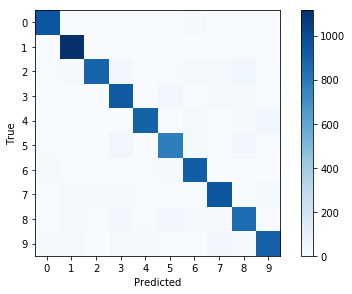

In [60]:
print_confusion_matrix()